In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import scipy.io

In [2]:
# Settings
input_path = os.path.join('../input/chiu-2015/2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

subject_path

['../input/chiu-2015/2015_BOE_Chiu/Subject_01.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_02.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_03.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_04.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_05.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_06.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_07.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_08.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_09.mat',
 '../input/chiu-2015/2015_BOE_Chiu/Subject_10.mat']

## Data Visualization

In [3]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

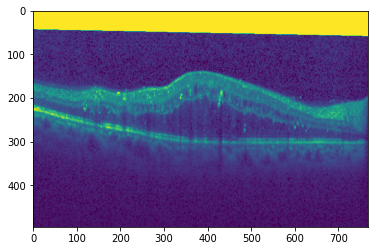

In [4]:
plt.imshow(img_array[25])

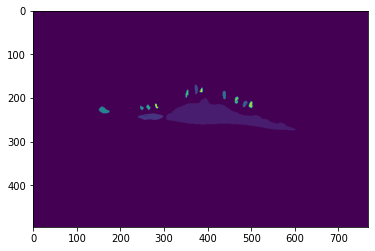

In [5]:
plt.imshow(manual_fluid_array[25])

In [6]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1
thresh = np.vectorize(thresh, otypes=[np.float])

In [7]:
def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

100%|██████████| 1/1 [00:13<00:00, 13.23s/it]


In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

## Unet

In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

In [10]:
batch_size = 9
epochs = 100
epoch_lapse = 20
threshold = 0.5
sample_size = None

In [11]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    dice = K.mean((2 * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(UNet, self).__init__()
        #Encode
        self.block1 = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=64),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=64, out_channels=64),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(64),
                )
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.block2 = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=64, out_channels=128),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=128, out_channels=128),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(128),
                )
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.block3 = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=128, out_channels=256),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=256, out_channels=256),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(256),
                )
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2)
        
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.decode3 = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=512, out_channels=256),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=256, out_channels=256),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
        
        self.decode2 = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=256, out_channels=128),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=128, out_channels=128),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
        self.final_layer = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=128, out_channels=64),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=64, out_channels=64),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=64, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels)
                    )
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        Concatenate the input from the previous convolution output
        from the encoding stage
        """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        
        # Encode Portion
        encode1 = self.block1(x)
        encode_pool1 = self.pool1(encode1)
        encode2 = self.block2(encode_pool1)
        encode_pool2 = self.pool2(encode2)
        encode3 = self.block3(encode_pool2)
        encode_pool3 = self.pool3(encode3)
        
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        
        # Decode - concatenate encode output with current input
        decode3 = self.crop_and_concat(bottleneck1, encode3, crop=True)
        cat_layer2 = self.decode3(decode3)
        decode2 = self.crop_and_concat(cat_layer2, encode2, crop=True)
        cat_layer1 = self.decode2(decode2)
        decode1 = self.crop_and_concat(cat_layer1, encode1, crop=True)
        final_layer = self.final_layer(decode1)

        return  final_layer

In [14]:
learning_rate = 0.01
unet = UNet(in_channels=1,out_channels=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)

In [15]:
batch_train_x = torch.from_numpy(x_train[0 * batch_size : (0 + 1) * batch_size]).float()
batch_train_y = torch.from_numpy(y_train[0 * batch_size : (0 + 1) * batch_size]).long()

unet(batch_train_x.cuda()).shape

torch.Size([9, 2, 196, 196])

In [16]:
def train_step(inputs, labels, optimizer, criterion, model):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [17]:
def get_val_loss(x_val, y_val, model):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = model(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [22]:
def get_val_metric(x_val, y_val, func, model): 
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = model(x_val)
    y_val_adj = np.transpose(y_val.cpu().detach().numpy(), (0, 2,3,1))[:, :,:,0]
    return func(torch.tensor(y_val_adj), outputs.argmax(1).cpu().detach().numpy())

In [19]:
def training_loop(model):
    epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
    t = trange(epochs, leave=True)
    for _ in t:
        total_loss = 0
        for i in range(epoch_iter):
            batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
            batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
            if use_gpu:
                batch_train_x = batch_train_x.cuda()
                batch_train_y = batch_train_y.cuda()
            batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion, model)
            total_loss += batch_loss
        if (_+1) % epoch_lapse == 0:
            val_loss = get_val_loss(x_val, y_val, model)
            print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

In [25]:
training_loop(unet)

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 20%|██        | 20/100 [01:17<05:21,  4.01s/it]

Total loss in epoch 20 : 0.6790105700492859 and validation loss : 0.45324647426605225


 40%|████      | 40/100 [02:34<04:00,  4.01s/it]

Total loss in epoch 40 : 0.6726005673408508 and validation loss : 0.519391655921936


 60%|██████    | 60/100 [03:52<02:40,  4.01s/it]

Total loss in epoch 60 : 0.6746424436569214 and validation loss : 0.5048854947090149


 80%|████████  | 80/100 [05:09<01:20,  4.01s/it]

Total loss in epoch 80 : 0.6740190982818604 and validation loss : 0.5056205987930298


100%|██████████| 100/100 [06:27<00:00,  3.87s/it]

Total loss in epoch 100 : 0.6741331815719604 and validation loss : 0.5068203210830688


## Check Metrics

In [27]:
validation_iou = get_val_metric(x_val, y_val, iou_coef, unet)
validation_dice_coef = get_val_metric(x_val, y_val, dice_coef, unet)

In [26]:
get_val_metric(x_val, y_val, iou_coef, unet)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2098794794232891>

In [28]:
print(f"For this particular model, got an IOU = {validation_iou} and Dice Coefficient = {validation_dice_coef}")

For this particular model, got an IOU = 0.2098794794232891 and Dice Coefficient = 0.2098794794232891


## Train Model on Full 1000 Epochs

In [29]:
batch_size = 9
epochs = 1000
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [30]:
learning_rate = 0.01
unet = UNet(in_channels=1,out_channels=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)

In [31]:
training_loop(unet)

  5%|▌         | 50/1000 [03:16<1:04:25,  4.07s/it]

Total loss in epoch 50 : 0.6615998148918152 and validation loss : 0.524323046207428


 10%|█         | 100/1000 [06:32<1:01:01,  4.07s/it]

Total loss in epoch 100 : 0.616852343082428 and validation loss : 0.5291527509689331


 15%|█▌        | 150/1000 [09:48<57:39,  4.07s/it]  

Total loss in epoch 150 : 0.3868536949157715 and validation loss : 0.6441729068756104


 20%|██        | 200/1000 [13:04<54:15,  4.07s/it]

Total loss in epoch 200 : 0.3244607746601105 and validation loss : 0.481014221906662


 25%|██▌       | 250/1000 [16:20<50:52,  4.07s/it]

Total loss in epoch 250 : 0.25949808955192566 and validation loss : 1.5351094007492065


 30%|███       | 300/1000 [19:36<47:28,  4.07s/it]

Total loss in epoch 300 : 0.25375089049339294 and validation loss : 1.5135823488235474


 35%|███▌      | 350/1000 [22:53<44:05,  4.07s/it]

Total loss in epoch 350 : 0.2610906660556793 and validation loss : 1.395108938217163


 40%|████      | 400/1000 [26:09<40:41,  4.07s/it]

Total loss in epoch 400 : 0.25046506524086 and validation loss : 1.673819899559021


 45%|████▌     | 450/1000 [29:25<37:17,  4.07s/it]

Total loss in epoch 450 : 0.2466493546962738 and validation loss : 1.6664350032806396


 50%|█████     | 500/1000 [32:41<33:54,  4.07s/it]

Total loss in epoch 500 : 0.24397796392440796 and validation loss : 1.701506495475769


 55%|█████▌    | 550/1000 [35:57<30:31,  4.07s/it]

Total loss in epoch 550 : 0.24197696149349213 and validation loss : 1.7585073709487915


 60%|██████    | 600/1000 [39:14<27:07,  4.07s/it]

Total loss in epoch 600 : 0.24005965888500214 and validation loss : 1.9492515325546265


 65%|██████▌   | 650/1000 [42:30<23:44,  4.07s/it]

Total loss in epoch 650 : 0.23896324634552002 and validation loss : 2.4461634159088135


 70%|███████   | 700/1000 [45:46<20:21,  4.07s/it]

Total loss in epoch 700 : 0.27146950364112854 and validation loss : 0.8164793848991394


 75%|███████▌  | 750/1000 [49:02<16:57,  4.07s/it]

Total loss in epoch 750 : 0.2570430636405945 and validation loss : 0.2823699116706848


 80%|████████  | 800/1000 [52:18<13:34,  4.07s/it]

Total loss in epoch 800 : 0.2548053562641144 and validation loss : 0.25804129242897034


 85%|████████▌ | 850/1000 [55:35<10:10,  4.07s/it]

Total loss in epoch 850 : 0.252583771944046 and validation loss : 0.32922083139419556


 90%|█████████ | 900/1000 [58:51<06:47,  4.07s/it]

Total loss in epoch 900 : 0.24582359194755554 and validation loss : 0.6605035066604614


 95%|█████████▌| 950/1000 [1:02:07<03:23,  4.07s/it]

Total loss in epoch 950 : 0.24098904430866241 and validation loss : 0.9159480333328247


100%|██████████| 1000/1000 [1:05:23<00:00,  3.92s/it]

Total loss in epoch 1000 : 0.23792733252048492 and validation loss : 1.0882768630981445


In [32]:
validation_iou = get_val_metric(x_val, y_val, iou_coef, unet)
validation_dice_coef = get_val_metric(x_val, y_val, dice_coef, unet)

In [33]:
print(f"For this particular model, got an IOU = {validation_iou} and Dice Coefficient = {validation_dice_coef}")

For this particular model, got an IOU = 0.00789852354179177 and Dice Coefficient = 0.015099137413976562


## Show Images

In [40]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        
        # change below line if using gpu
        # check the one image
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).cpu().detach().numpy()
        
        y_true = np.transpose(image_arr, (1,2,0))[:,:,0]
        y_pred = np.transpose(datay[image_indx], (1,2,0))[:,:,0]
        
        
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

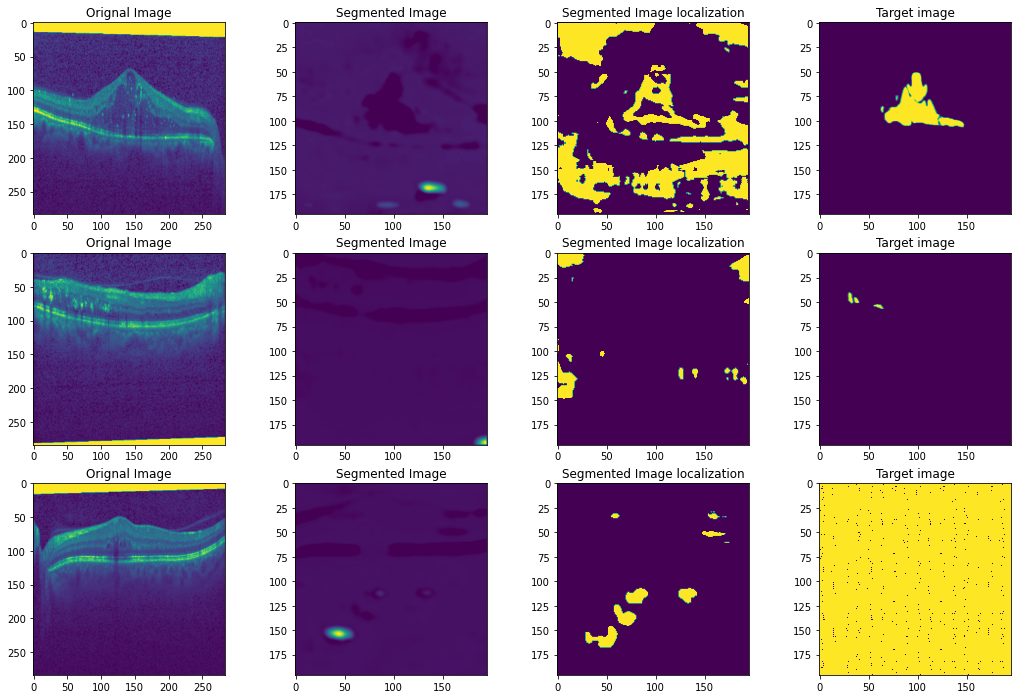

In [43]:
plot_examples(x_train, y_train)